In [13]:
%matplotlib widget

from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
from math import comb
from sympy.utilities.lambdify import lambdify

from typing import Callable
from montecarlo import monte_carlo, MonteCarloEstimate



In [14]:
# functions from the in class notebook
def bernoulli_rw_steps(steps):
    """ Generate a set of steps for a random walk"""
    X = np.random.rand(steps)  # samples from a uniform
    # Inverse CDF Trick
    X[X > 0.5] = 1.0
    X[X < 0.5] = -1.0
    return X


def bernoulli_rw(steps, shrink):
    """Generate a random walk that is shrunk in space and sped up in time from a sequence of steps"""
    Y = np.concatenate((np.array([0]), np.cumsum(steps)/np.sqrt(shrink)))
    return Y


@dataclass
class ImportanceSamplingEstimate:
    mc: MonteCarloEstimate
    weights: np.ndarray


def importance_sampling(num_samples: int,
                        proposal_sample_generator: Callable[[int], np.ndarray],
                        proposal_pdf_evaluator: Callable[[np.ndarray], np.ndarray],
                        base_pdf_evaluator: Callable[[np.ndarray], np.ndarray],
                        g_evaluator: Callable[[np.ndarray], np.ndarray]) -> ImportanceSamplingEstimate:
    """Perform importance sampling.

    Note that the code is basically the same as Monte Carlo, but with a set of weights.

    Args:

        num_samples: number of samples
        proposal_sample_generator: A function that generates samples with signature sample_generator(nsamples)
        proposal_pdf_evaluator: evaluate the pdf of the proposal.
        base_pdf_evaluator: evaluate the pdf of the underlying random variable.
        g_evaluator: a function that takes as inputs the samples and outputs the evaluations.
                     The outputs can be any dimension, however the first dimension should have size *num_samples*

    Returns:

        An importance sampling estimator.
    """
    samples = proposal_sample_generator(num_samples)
    weights = base_pdf_evaluator(samples) / proposal_pdf_evaluator(samples)
    evaluations = g_evaluator(samples)
    estimate = np.sum(evaluations * weights, axis=0) / float(num_samples)

    ret = ImportanceSamplingEstimate(MonteCarloEstimate(
        estimate, samples, evaluations), weights)
    return ret

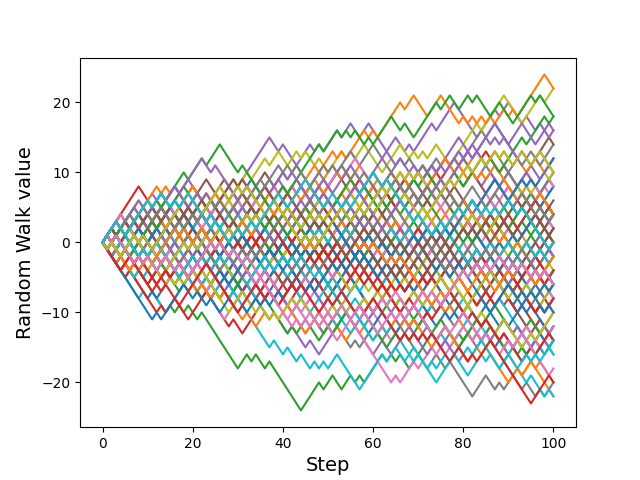

In [15]:
# 2.1.a N-step random walk
nsteps = 100
nwalks = 100
np.random.seed(10)  # fix seed for reproducibility
plt.figure()
for w in range(nwalks):
    walk = bernoulli_rw(bernoulli_rw_steps(nsteps), 1)
    plt.plot(range(nsteps+1), walk, '-')
plt.xlabel('Step', fontsize=14)
plt.ylabel('Random Walk value', fontsize=14)
plt.savefig('figs/3.1.svg')
# plt.show()

In [16]:
# 2.1.b compute the probability of S > 10
nsteps = 100
ntrials = 10**5
# simple random walk for MC sampling
walks = np.array([np.sum(bernoulli_rw_steps(nsteps)) for _ in range(ntrials)])
# use an indicator function to calculate the probability S > 10
walks_indicator = np.where(walks > 10, 1, 0)
mc_estimate = np.mean(walks_indicator)
mc_estimate_var = np.var(walks_indicator)
print(
    f"MC estimate with {ntrials} trials with {nsteps} steps in each trial for P(S>10): {mc_estimate} and var: {mc_estimate_var}")

MC estimate with 100000 trials with 100 steps in each trial for P(S>10): 0.13585 and var: 0.11739477750000003


Mean of the random walks: 0.03948
Variance of the random walks: 100.09668132960002
IS estimate with 100000 trials for P(S>55): 3.872591914849296e-21


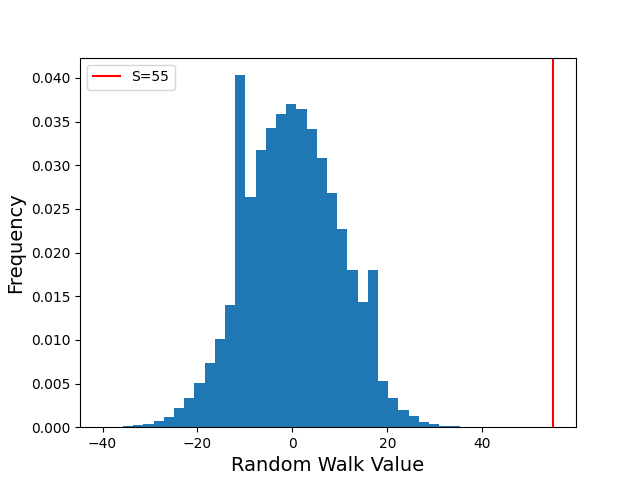

In [17]:
# 2.1.c importance sampling with P(S > 55)
# generate the probability distribution for the random walk
nsteps = 100
ntrials = 10**5
# simple random walk for MC sampling
walks = np.array([np.sum(bernoulli_rw_steps(nsteps)) for _ in range(ntrials)])
print(f"Mean of the random walks: {np.mean(walks)}")
print(f"Variance of the random walks: {np.var(walks)}")
plt.figure()
plt.hist(walks, bins=40, density=True)
plt.axvline(55, color='r', label='S=55')
plt.xlabel('Random Walk Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.savefig('figs/3.2.svg')


def prop_bernoulli_rw_steps(steps):
    """ Generate a set of steps for a random walk with p=0.8"""
    P_PROP = 0.8
    X = np.random.rand(steps)  # samples from a uniform
    # Inverse CDF Trick
    X[X > 0.2] = 1.0
    X[X < 0.2] = -1.0
    return X


def prop_bernoulli_rw(ntrials):
    """proposal_sampler, Generate a random walk from a sequence of steps"""
    STEPS = 100
    walks = np.array([prop_bernoulli_rw_steps(STEPS) for _ in range(ntrials)])
    return walks


def prop_bernoulli_rw_pdf(samples):
    """proposal_pdf_evaluator, Evaluate the pdf of the proposal distribution"""
    plus_1_samples = np.where(samples == 1, 1, 0)
    minus_1_samples = np.where(samples == -1, 1, 0)
    return np.prod((0.8 * plus_1_samples + 0.2 * minus_1_samples), axis=1)


def bernoulli_rw_pdf(samples):
    """base_pdf_evaluator, Evaluate the pdf of the proposal distribution"""
    plus_1_samples = np.where(samples == 1, 1, 0)
    minus_1_samples = np.where(samples == -1, 1, 0)
    return np.prod(0.5*(plus_1_samples + minus_1_samples), axis=1)


def gfunc(samples):
    """Evaluate the indicator function for S > 55"""
    return np.where(np.sum(samples, axis=1) > 55, 1, 0)


ntrials = 10**5
IS_est = importance_sampling(
    ntrials, prop_bernoulli_rw, prop_bernoulli_rw_pdf, bernoulli_rw_pdf, gfunc)
print(f"IS estimate with {ntrials} trials for P(S>55): {IS_est.mc.estimate}")

In [11]:
# 2.1.d analytical solution
nsteps = 100
p = 0.5
S = 55
point5to100 = 0.5**100
psgthn55 = np.sum(
    [comb(100, int((i+100)/2)) * point5to100 for i in range(S+1, nsteps+1, 2)])
# print([(i+100)/2 for i in range(S+1, nsteps+1, 2)])

print(
    f"Analytical solution for P(S>55): {psgthn55}")
print(
    f"Differs from IS estimate by {abs(psgthn55-IS_est.mc.estimate)/psgthn55*100:.2f}%")

Analytical solution for P(S>55): 7.95266423689307e-09
Differs from IS estimate by 0.17%


In [8]:
# 2.1.e.i standard error and CI

# standard error for MC
mc_se = np.sqrt(mc_estimate_var/ntrials)
# 95% confidence interval for MC
# z =
mc_ci = [mc_estimate - 1.96*mc_se, mc_estimate + 1.96*mc_se]
print(f"MC std error: {mc_se} and 95% CI: {mc_ci}")

# standard error for IS
is_se = np.sqrt(np.var(IS_est.mc.evaluations) / ntrials)
# 95% confidence interval for IS
is_ci = [IS_est.mc.estimate - 1.96*is_se, IS_est.mc.estimate + 1.96*is_se]
print(f"IS std error: {is_se} and 95% CI: {is_ci}")

MC std error: 0.0010834887055248892 and 95% CI: [0.1337263621371712, 0.1379736378628288]
IS std error: 0.0013852787387381644 and 95% CI: [-0.002715138361486841, 0.0027151542943667636]
